In [2]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform 
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

#Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion() #interactive mode


In [4]:
landmarks_frame = pd.read_csv('faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: \n {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: 
 [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


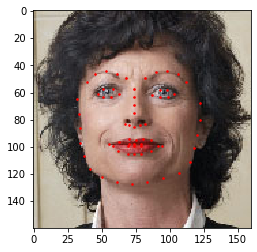

In [5]:
def show_landmarks(image, landmarks):
    """show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.',c='r')
    plt.pause(0.001) #pause a bit sothat plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('faces/', img_name)), landmarks)
plt.show()

In [15]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset"""

    def __init__(self, csv_file, root_dir, transform=None):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)

        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks' : landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample



0 (324, 215, 3) (68, 2)
1 (500, 333, 3) (68, 2)
2 (250, 258, 3) (68, 2)
3 (434, 290, 3) (68, 2)


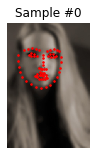

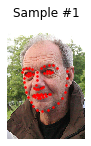

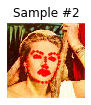

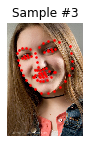

In [18]:
face_dataset = FaceLandmarksDataset(csv_file='faces/face_landmarks.csv', root_dir='faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break



In [ ]:
class Rescale(object):
    """Rescale the image in a sample to a given size.
    Args:
    output_size(tuple or int): Desired output size. If tuple, output is matched to out put_size. If int, smaller of image edges is matched to output_size keeping aspect ratio the same."""

    def __init__(self, outputsize):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h,w = image.shape[:2]
        if isinstance(self.output_size,int):
            if h>w:
                new_h, new_w = self.output_size * h/w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w/h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_w, new_w))

        landmarks = landmarks * [new_w / w, new_h / h]

        return{'image': img, 'landmarks': landmarks}

    class RandomCrop(object):
        
